# Design of a Hydronic Pipe Network

This notebook demonstrates the design of a hydronic heating system, using the `hvac.fluid_flow` package.

In [1]:
import warnings
from hvac.fluids import CoolPropWarning

warnings.filterwarnings('ignore', category=CoolPropWarning)

In [2]:
import pandas as pd
from IPython.display import display, HTML

In [3]:
from hvac import Quantity
from hvac.fluid_flow import PipeNetwork, PipeScheduleFactory
from hvac.fluids import Fluid

In [4]:
Q_ = Quantity

## Hydronic Network Scheme

![scheme](hydronic_network.png)

## Define the Fluid in the Pipe Network

In a hydronic heating system, water is being used as a heat carrier to transport heat from the heating generator(s) to the heating emitter(s).

In [5]:
Water = Fluid('Water')
heating_water = Water(T=Q_(50, 'degC'), P=Q_(2, 'bar'))

## Configuration of the Pipe Network

The configuration of a fluid flow network can be done in a spreadsheet program, like Excel or OpenOffice Calc. Each row of the spreadsheet table represents a pipe in the network. The interconnection of pipes in the network happens with nodes. Each pipe has a start node and an end node, as shown by the dots in the network scheme above. The nodes allow the program to find out how the pipes in the network are interconnected. The first row of the spreadsheet table is the header. The header labels cannot be chosen freely; they must be known by the program. In the code block below, the spreadsheet table for this example is displayed to show how the table looks like in the spreadsheet program:

In [6]:
table = pd.read_csv('network_config.csv')
display(HTML(table.to_html()))

This table is used to design a pipe network. When designing a pipe network, the length and the design volume flow rate of each pipe are already known. A reasonable specific pressure drop needs to be chosen for each pipe. In this case, a specific pressure drop of 0.2 kPa/m has been selected. Notice that there are no measuring units mentioned in the table. We can use any appropriate unit we want for a certain quantity, but later on we will have to tell the program which units we are using. In the last column *schedule* a name has been entered that refers to a collection of commercially available pipe sizes. More explanation about this feature will follow, but first a worth about the header labels:
- The column *conduit_ID* contains a reference name or ID for each pipe in the network.
- The column *start_node_ID* specifies the ID of the pipe's start node, i.e. the node where the fluid leaves.
- The column *end_node_ID* specifies the ID of the pipe's end node, i.e. the node where the fluid arrives.
- The column *loop_ID* is not required, and thus optional, when designing a pipe network, but we will need this if we want to analyze our network later on with the Hardy Cross method. This will be explained in a subsequent notebook where we will analyze the network when control valves are closed more.
- The column *schedule* contains a reference name (that you can choose freely) to a collection of commercially available pipe sizes. When designing a network, this column is optional. You can also assign only one schedule to the whole network if all pipes in the network are of the same family. Or you could omit the schedule, but then theoretical pipe diameters will be returned, which probably won't be commercially available.
- The column *length* contains the length of each pipe (expressed in units you prefer)
- The column *volume_flow_rate* contains the design volume flow rate in each pipe (expressed in units you prefer)
- The column *specific_pressure_drop* contains the pressure drop per unit pipe length (expressed in units you prefer)

These header labels are needed when designing a pipe network. But there are more header labels defined in the program that can or will be needed when designing a duct network or when analyzing an existing pipe or duct network. These additional header labels will be discussed in other notebooks.

> **IMPORTANT!**<br>
> When the table in the spreadsheet program is ready, you must save it as a comma-separated-values (csv) file, as this is the only file format that can be loaded by the program. Also be aware for the decimal point. It must be a point, not a comma! If the latter case is true, you can easily change this in the spreadsheet program, e.g. by selecting the table or the whole sheet and then changing the language formatting to a format that uses a point to separate the decimals of a number before saving as a csv-file.

## Sizing the Pipes in the Network

### Loading the Pipe Schedules

As can be seen in the table above, we use two different names to reference two different collections of commercially available pipes, which are called *schedules*; "copper" refers to copper tubes, while "pex" refers to PEX-AL-PEX tubing.

The program can use any schedule you want. For this, you need to make a "schedule table" in a spreadsheet program. The following code shows a fragment of the spreadsheet table for "copper":

In [7]:
schedule_table = pd.read_excel(
    io="./pipe_schedules/copper_tube.ods",
    sheet_name=0,
    header=0
)
display(HTML(schedule_table.head().to_html()))

As you can see, the header of the spreadsheet table must have these 4 labels:
- the column labeled *D_nom* contains the available nominal pipe diameters
- the column labeled *D_ext* contains the corresponding exterior diameters
- the column labeled *t* contains the corresponding pipe wall thicknesses
- the column labeled *D_int* contains the corresponding interior diameters

The values can be expressed in any appropriate measuring unit you prefer; however, this unit must be the same for all values in the table.

Having the spreadsheet files saved at a known file location, we can now create the schedules as follows:

In [8]:
copper_schedule = PipeScheduleFactory.get(
    name='copper',
    file_path='./pipe_schedules/copper_tube.ods',
    unit='mm'
)

We assign the reference name we have used in the pipe network configuration file to the parameter `name`. Next, we specify the file path where the schedule file is stored and the unit in which we have expressed the values of the pipe diameters in the table. (The default unit is already mm, so we could have omitted the parameter `unit` here; however, it's included for completeness.) Now, we can do exactly the same thing to create our "pex" schedule:

In [9]:
pex_schedule = PipeScheduleFactory.get(
    name='pex',
    file_path='./pipe_schedules/henco_standard_pex.ods',
)

### Creating the Closed Pipe Network

In [10]:
pipe_network = PipeNetwork.create(
    ID='heating_system',
    fluid=heating_water,
    wall_roughness=Q_(0.0015, 'mm'),
    schedule=None,
    start_node_ID='S0',
    end_node_ID='R0'
)

A pipe network is created by calling the class method `create` of the `PipeNetwork` class. The code block above shows which parameters the method needs to create a closed pipe network. A closed pipe network is a network that has a start node, where fluid enters the network, and an end node, where fluid leaves the network. (However, it is also possible to configure a so-called open pipe network, which has multiple end nodes, e.g., a drinking water distribution system, which will be demonstrated in another example).

Through parameter `wall_roughness` the absolute pipe wall roughness of all pipes in the network is set. If not all pipes in the network have the same absolute roughness, you can add a column *wall_roughness* to the pipe network configuration file and then set the parameter `wall_roughness` in the call to method `create` to `None`.

The parameter `schedule` has been set to `None`, as not all pipes in the network belong to the same schedule.

### Setting Units

Before we move on, we must make sure that the program will do the calculations with the units we have been using when writing the pipe network configuration file. Units can be set through attribute `units` of the `PipeNetwork` object we've just created. Units can be assigned to the following quantities:

| quantity                     | keyword                | default unit                                          |
|------------------------------|------------------------|-------------------------------------------------------|
| pipe length                  | 'length'               | 'm'                                                   |
| diameter                     | 'diameter'             | 'mm'                                                  |
| width (duct)                 | 'dim_width'            | 'mm'                                                  |
| height (duct)                | 'dim_height'           | 'mm'                                                  |
| volume flow rate             | 'volume_flow_rate'     | 'm ** 3 / s'                                          |
| flow velocity                | 'velocity'             | 'm / s'                                               |
| pressure (difference)        | 'pressure'             | 'Pa'                                                  |
| specific pressure drop       | 'specific_pressure'    | 'Pa / m'                                              |
| pressure head                | 'pressure_head         | 'Pa'                                                  |
| altitude (elevation)         | 'height'               | 'm'                                                   |
| absolute pipe wall roughness | 'wall_roughness'       | 'mm'                                                  |
| pump or fan coefficients     | 'machine_coefficients' | ['Pa', 'Pa / (m ** 3 / s)', 'Pa / (m ** 3 / s) ** 2'] |

In our example, volume flow rate is expressed in units of L/s, and specific pressure drop in units of kPa/m. Furthermore, we want pressure and pressure difference to be expressed in units of kPa.

In [11]:
pipe_network.units['volume_flow_rate'] = 'L / s'
pipe_network.units['pressure'] = 'kPa'
pipe_network.units['specific_pressure'] = 'kPa / m'

### Load the Pipe Network Configuration File into the `PipeNetwork` Instance

In [12]:
pipe_network.load_from_csv('network_config.csv')

When the method `load_from_csv` is called, the program will immediately calculate the required diameter of each pipe. We can get an overview of the pipes in the network by calling the method `get_pipe_table`, which returns a Pandas `DataFrame` object.

In [13]:
display(HTML(pipe_network.get_pipe_table().to_html()))

## Add Fittings to the Pipe Network

After all pipe diameters in the network are calculated, we can add fittings to the pipes. To add fittings to a pipe, we need to import module `hvac.fluid_flow.fittings.pipe`:

In [14]:
from hvac.fluid_flow.fittings import pipe as pipe_fittings

### Tees

For a number of pipe fittings and valves, the resistance coefficient can be calculated with the formulas of the well-known technical guide TP-410M by Crane. These fittings and valves are located in module `crane.py` of the above-mentioned package. In the following, we will add tees at the nodes of the cross-overs in the network. On the supply side of the network (with the 'S*x*' labeled nodes in the scheme above) the fluid flow at the nodes is diverging, while on the return side of the network (with the 'R*x*' labeled nodes) the fluid flow is converging. The 'combined pipe' of a tee is where the fluid flows from the branch and straight leg combine (i.e. the sum of flow through the branch and through the straight leg). To create a tee at node S1, the following code will do:

In [15]:
tee_S1 = pipe_fittings.Tee(
    flow_pattern='diverging',
    combined_pipe=pipe_network.conduits['P1'],
    branch_pipe=pipe_network.conduits['P5'],
    ID='TEE-S1'
)

We can access the pipes in the network through attribute `conduits`, which is a dictionary of which the keys are the ID's we gave to our pipes in the network configuration file. After a tee has been created, we still need to assign the resistance coefficient of the tee to the pipes. In the case of a tee fitting we have two resistance coefficients: one in the combined leg (`zeta_c`) and one in the branch leg (`zeta_b`):

In [16]:
pipe_network.conduits['P1'].add_fitting(tee_S1.zeta_c, tee_S1.ID)
pipe_network.conduits['P5'].add_fitting(tee_S1.zeta_b, tee_S1.ID)

In the same way, we add the diverging tees to nodes S2 and S3 and the converging tees to nodes R1, R2, and R3. 

In [17]:
tee_S2 = pipe_fittings.Tee(
    flow_pattern='diverging',
    combined_pipe=pipe_network.conduits['P2'],
    branch_pipe=pipe_network.conduits['P6'],
    ID='TEE-S2'
)
pipe_network.conduits['P2'].add_fitting(tee_S2.zeta_c, tee_S2.ID)
pipe_network.conduits['P6'].add_fitting(tee_S2.zeta_b, tee_S2.ID)

tee_S3 = pipe_fittings.Tee(
    flow_pattern='diverging',
    combined_pipe=pipe_network.conduits['P3'],
    branch_pipe=pipe_network.conduits['P7'],
    ID='TEE-S3'
)
pipe_network.conduits['P3'].add_fitting(tee_S3.zeta_c, tee_S3.ID)
pipe_network.conduits['P7'].add_fitting(tee_S3.zeta_b, tee_S3.ID)

tee_R1 = pipe_fittings.Tee(
    flow_pattern='converging',
    combined_pipe=pipe_network.conduits['P12'],
    branch_pipe=pipe_network.conduits['P5'],
    ID='TEE-R1'
)
pipe_network.conduits['P12'].add_fitting(tee_R1.zeta_c, tee_R1.ID)
pipe_network.conduits['P5'].add_fitting(tee_R1.zeta_b, tee_R1.ID)

tee_R2 = pipe_fittings.Tee(
    flow_pattern='converging',
    combined_pipe=pipe_network.conduits['P11'],
    branch_pipe=pipe_network.conduits['P6'],
    ID='TEE-R2'
)
pipe_network.conduits['P11'].add_fitting(tee_R2.zeta_c, tee_R2.ID)
pipe_network.conduits['P6'].add_fitting(tee_R2.zeta_b, tee_R2.ID)

tee_R3 = pipe_fittings.Tee(
    flow_pattern='converging',
    combined_pipe=pipe_network.conduits['P10'],
    branch_pipe=pipe_network.conduits['P7'],
    ID='TEE-R3'
)
pipe_network.conduits['P10'].add_fitting(tee_R3.zeta_c, tee_R3.ID)
pipe_network.conduits['P7'].add_fitting(tee_R3.zeta_b, tee_R3.ID)

### Reducers and Enlargers

On the supply side, the diameter of pipe P1 is larger than the diameter of pipe P2, the diameter of pipe P2 is larger than the diameter of pipe P3, and the diameter of pipe P3 is larger than the diameter of pipe P4. On the return side, the reverse is true. Therefore, we will add reducers on the supply side and enlargers on the return side. Reducers will be positioned at the start of the smallest pipe (notice `zeta_small`, i.e., the resistance coefficient of the reducer referenced to the pipe with the smaller diameter), while enlargers will be positioned at the start of the largest pipe (notice `zeta_large`). Parameter `L` is the length of the reducer or enlarger.

In [18]:
reducer_S1 = pipe_fittings.Reducer(
    large_pipe=pipe_network.conduits['P1'],
    small_pipe=pipe_network.conduits['P2'],
    L=Q_(5.0, 'cm'),
    ID='RED-S1'
)
pipe_network.conduits['P2'].add_fitting(reducer_S1.zeta_small, reducer_S1.ID)

reducer_S2 = pipe_fittings.Reducer(
    large_pipe=pipe_network.conduits['P2'],
    small_pipe=pipe_network.conduits['P3'],
    L=Q_(5.0, 'cm'),
    ID='RED-S2'
)
pipe_network.conduits['P3'].add_fitting(reducer_S2.zeta_small, reducer_S2.ID)

reducer_S3 = pipe_fittings.Reducer(
    large_pipe=pipe_network.conduits['P3'],
    small_pipe=pipe_network.conduits['P4'],
    L=Q_(5.0, 'cm'),
    ID='RED-S3'
)
pipe_network.conduits['P4'].add_fitting(reducer_S3.zeta_small, reducer_S3.ID)

enlarger_R1 = pipe_fittings.Enlarger(
    large_pipe=pipe_network.conduits['P12'],
    small_pipe=pipe_network.conduits['P11'],
    L=Q_(5.0, 'cm'),
    ID='ENL-R1'
)
pipe_network.conduits['P12'].add_fitting(enlarger_R1.zeta_large, enlarger_R1.ID)

enlarger_R2 = pipe_fittings.Enlarger(
    large_pipe=pipe_network.conduits['P11'],
    small_pipe=pipe_network.conduits['P10'],
    L=Q_(5.0, 'cm'),
    ID='ENL-R2'
)
pipe_network.conduits['P11'].add_fitting(enlarger_R2.zeta_large, enlarger_R2.ID)

enlarger_R3 = pipe_fittings.Enlarger(
    large_pipe=pipe_network.conduits['P10'],
    small_pipe=pipe_network.conduits['P9'],
    L=Q_(5.0, 'cm'),
    ID='ENL-R3'
)
pipe_network.conduits['P10'].add_fitting(enlarger_R3.zeta_large, enlarger_R3.ID)

### Elbows

At nodes S4 and R4, elbows are located. Elbows don't have a dedicated class. For this you can use the general `PipeFitting` class. A pipe fitting can be specified in a number of different ways:
- using a flow coefficient *K<sub>v</sub>*, which is usually applicable to valves
- using the 3K-method, which implies that a fitting is characterized by three different resistance coefficients: *zeta*, *zeta_d* and *zeta_inf*
- using Crane's *equivalent length ratio* (*ELR*); see Crane TP-410M
- using a single value *zeta* for the resistance coefficient taken from a catalog of fittings

Any of these possibilities can be used to create a `PipeFitting` object (for this, you can have a look at the source code in module `hvac.fluid_flow.fittings.pipe.general`). In this example, we will use ELR.

In [19]:
elbow_S4 = pipe_fittings.PipeFitting(
    pipe=pipe_network.conduits['P4'],
    ID='ELBOW-S4',
    ELR=30
)
pipe_network.conduits['P4'].add_fitting(elbow_S4.zeta, elbow_S4.ID)

elbow_R4 = pipe_fittings.PipeFitting(
    pipe=pipe_network.conduits['P9'],
    ID='ELBOW-R4',
    ELR=30
)
pipe_network.conduits['P9'].add_fitting(elbow_R4.zeta, elbow_R4.ID)

## Pipes, Fittings and Flow Paths Overview (Take 1)

### Pipes

In [20]:
display(HTML(pipe_network.get_pipe_table().to_html()))

### Fittings

In [21]:
display(HTML(pipe_network.get_fitting_table().to_html()))

### Flow Paths

In [22]:
display(HTML(pipe_network.get_flow_path_table().to_html()))

Calling method `get_flow_path_table` returns a Pandas `DataFrame` object with all the flow paths between the start and end node of the network. The first column *Δp-elev* refers to the gravity, stack or chimney effect, which is due to the elevation difference between the start and end node of the network and due to the density difference between the fluid and the ambient air. In a hydronic, closed system this term will always be zero. The second column *Δp-dyn* refers to the pressure loss due to pipe friction and dynamic effects in fittings and valves. The third column *Δp-tot* is the sum of the first two columns. The last column *Δp-deficit* refers to the difference in total pressure between the critical flow path (i.e. the path having the greatest pressure loss) and the other flow paths between the start and end node of the network. For the critical path, this value will obviously be zero. In a perfectly balanced pipe network, all flow paths will have a pressure difference deficit nearing to zero.

## Add Balancing Valves to the Cross-Overs in the Network

### Calculate Preliminary Flow Coefficients

In a balanced network, the total pressure loss along each flow path will be equal to the pressure loss along the critical path of the network, when the design flow rates are flowing in each pipe of the pipe network. In other words, *Δp-deficit* of each flow path should be close to zero. If that is the case, there will be no preferential flow paths in the network, and the design flow rates will actually be flowing through each pipe of the network.

Balancing valves are placed in the cross-overs between the supply and return side, so that flow paths have no balancing valves in common. First, a preliminary flow or valve coefficient is calculated, such that a certain prescribed pressure drop is present across the balancing valve when it is fully open. Normally, a pressure drop of 3 kPa is recommended.

In [23]:
cross_over_IDs = ['P5', 'P6', 'P7', 'P8']

Kvs_pre_list = [
    pipe_network.add_balancing_valve(
        cross_over_ID=cross_over_ID, 
        pressure_drop_full_open=Q_(3, 'kPa')
    )
    for cross_over_ID in cross_over_IDs
]

for item in [
    f"- preliminary Kvs of balancing valve in {cross_over_ID} = {Kvs_pre}"
    for cross_over_ID, Kvs_pre in zip(cross_over_IDs, Kvs_pre_list)
]:
    print(item)

- preliminary Kvs of balancing valve in P5 = 1.2608467334744375
- preliminary Kvs of balancing valve in P6 = 3.782540200423313
- preliminary Kvs of balancing valve in P7 = 1.9016049095024303
- preliminary Kvs of balancing valve in P8 = 2.521693466948875


### Balancing Valve Selection

Based on the pipe size and preliminary Kvs, a balancing valve can now be selected. In this example, the following balancing valves were selected:
- cross-over P5: Kvs = 1.33
- cross-over P6: Kvs = 5.35
- cross-over P7: Kvs = 2.32
- cross-over P8: Kvs = 2.32

In [24]:
Kvs_list = [1.33, 5.35, 2.32, 2.32]

for cross_over_ID, Kvs in zip(cross_over_IDs, Kvs_list):
    pipe_network.set_balancing_valve_Kvs(cross_over_ID, Kvs)

## Add Control Valves to the Cross-Overs

### Calculate Preliminary Flow Coefficients

The control valves in the cross-overs serve to control the volume flow rate through the heat emitters in the hydronic distribution system during part-load conditions. They are installed upstream of the heat emitter they control. First, a preliminary flow coefficient is calculated based on a target value for the valve authority. This target value should be at least 0.5 to attain a good controllability of the control valve.

In [25]:
Kvs_pre_list = [
    pipe_network.add_control_valve(
        cross_over_ID=cross_over_ID, 
        target_authority=0.5
    )
    for cross_over_ID in cross_over_IDs
]

for item in [
    f"preliminary Kvs of control valve in {cross_over_ID} = {Kvs_pre}"
    for cross_over_ID, Kvs_pre in zip(cross_over_IDs, Kvs_pre_list)
]:
    print(item)

preliminary Kvs of control valve in P5 = 0.573935179185883
preliminary Kvs of control valve in P6 = 1.721805537557649
preliminary Kvs of control valve in P7 = 0.8656071554934628
preliminary Kvs of control valve in P8 = 1.147870358371766


### Control Valve Selection

In the same way as we did with the balancing valves, the actual control valves can now be selected and their Kvs-values be entered in the program: 

In [26]:
Kvs_list = [0.4, 1.6, 0.63, 1.0]

for cross_over_ID, Kvs in zip(cross_over_IDs, Kvs_list):
    pipe_network.set_control_valve_Kvs(cross_over_ID, Kvs)

## Pipes, Fittings and Flow Paths Overview (Take 2)

### Pipes

In [27]:
display(HTML(pipe_network.get_pipe_table().to_html()))

### Fittings and Valves

In [28]:
display(HTML(pipe_network.get_fitting_table().to_html()))

### Flow Paths

In [29]:
display(HTML(pipe_network.get_flow_path_table().to_html()))

## Statically Balance the Network for Design Volume Flow Rates 

To let the program balance the flow paths, simply call:

In [30]:
pipe_network.balance_network_at_design()

Now, we can check the required Kvr-settings of the balancing valves:

In [31]:
display(HTML(pipe_network.get_balancing_valve_table().to_html()))

## Pipes, Fittings and Flow Paths Overview (Take 3)

### Pipes

In [32]:
display(HTML(pipe_network.get_pipe_table().to_html()))

### Fittings and Valves

In [33]:
display(HTML(pipe_network.get_fitting_table().to_html()))

### Flow Paths

In [34]:
display(pipe_network.get_flow_path_table())

path  Δp-elev. [kPa]  Δp-dyn. [kPa]  \
0  P1|P2|P3|P4|P8|P9|P10|P11|P12             0.0       38.99701   
1                      P1|P5|P12             0.0       38.99701   
2               P1|P2|P6|P11|P12             0.0       38.99701   
3        P1|P2|P3|P7|P10|P11|P12             0.0       38.99701   

   Δp-tot. [kPa]  Δp-deficit [kPa]  
0       38.99701      0.000000e+00  
1       38.99701      7.275958e-15  
2       38.99701      7.275958e-15  
3       38.99701      1.455192e-14

## Checking Control Valve Authorities

Finally, we should check the control valve authorities in the balanced network. The authority of a modulating control valve should not be smaller than 0.25.

In [35]:
display(HTML(pipe_network.get_control_valve_table().to_html()))

## Drawing the System Curve of the Network

Between the start and end node of the balanced pipe network, the pressure difference will be equal to the pressure loss along the critical path. As the network is balanced, each flow path between the start and end node of the network produces the same pressure loss, as can be seen in the flow path table above. The ratio of the pressure difference to the square of the volume flow rate that enters the network through the start node (and leaves through the end node) is a measure of the network's hydraulic resistance. If the volume flow rate into the network changes, the hydraulic resistance of the network will remain the same, and as such, the pressure difference between the start node and end node of the network will change accordingly to the square of the volume flow rate. The relationship between volume flow rate through and pressure difference across the hydraulic resistance of a pipe network is graphically shown by the system curve. However, if the opening of any control valve in the network changes, the hydraulic resistance of the network will also change. Consequently, the system curve will also change. Moreover, the network won't be (perfectly) balanced anymore, meaning that volume flow rates through other cross-overs will also inevitably change. This will be demonstrated in another example.

In [36]:
from hvac.fluid_flow.utils import SystemCurve

In [37]:
system_curve = SystemCurve.create(pipe_network.hydraulic_resistance)

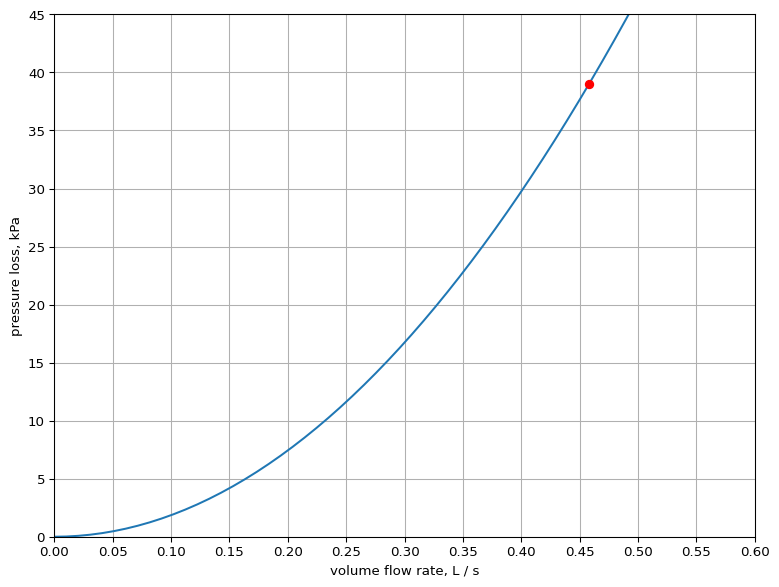

In [38]:
diagram = system_curve.diagram(
    V_ini=Q_(0.0, 'L / s'),
    V_fin=Q_(0.5, 'L / s'),
    V_design=pipe_network.volume_flow_rate,
    no_points=50,
    fig_size=(8, 6),
    dpi=96,
    V_step=Q_(0.05, 'L / s'),
    V_max=Q_(0.65, 'L / s'),
    dP_step=Q_(5.0, 'kPa'),
    dP_max=Q_(50.0, 'kPa'),
    V_unit='L / s',
    dP_unit='kPa'
)
diagram.show()

## Save the Pipe Network for Later Use

We will re-use the hydronic pipe network in a subsequent example in which we will analyze how closing control valves affect the volume flow rates in the pipe network. Therefore, we save this pipe network on disk:

In [39]:
from hvac.fluid_flow.network import save_network

save_network(pipe_network, "hydronic_network.pickle")